Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Read and clean the data

,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,parentspecies,...,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,pSat_Pa
0,0,30.010565,4,1,1,0,0,1,1,apin_decane_toluene,...,0,0,0,0,0,0,0,0,0,641974.491
1,1,74.995643,6,1,3,1,0,1,1,toluene,...,0,0,1,0,0,0,0,0,0,10295.712
2,2,102.990558,8,2,4,1,0,2,2,toluene,...,0,0,1,0,0,0,0,0,0,13517.575
3,3,118.985472,9,2,5,1,1,3,1,toluene,...,0,0,1,0,0,0,0,0,0,241.630
4,4,134.980387,10,2,6,1,1,3,3,toluene,...,0,0,1,0,0,0,0,1,0,315.357


,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,parentspecies,...,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,pSat_Pa
0,0,30.010565,4,1,1,0,0,1,1,3,...,0,0,0,0,0,0,0,0,0,5.807518
1,1,74.995643,6,1,3,1,0,1,1,7,...,0,0,1,0,0,0,0,0,0,4.012656
2,2,102.990558,8,2,4,1,0,2,2,7,...,0,0,1,0,0,0,0,0,0,4.130899
3,3,118.985472,9,2,5,1,1,3,1,7,...,0,0,1,0,0,0,0,0,0,2.383151
4,4,134.980387,10,2,6,1,1,3,3,7,...,0,0,1,0,0,0,0,1,0,2.498802


Id                              0
MW                              0
NumOfAtoms                      0
NumOfC                          0
NumOfO                          0
NumOfN                          0
NumHBondDonors                  0
NumOfConf                       0
NumOfConfUsed                   0
parentspecies                   0
C.C..non.aromatic.              0
C.C.C.O.in.non.aromatic.ring    0
hydroxyl..alkyl.                0
aldehyde                        0
ketone                          0
carboxylic.acid                 0
ester                           0
ether..alicyclic.               0
nitrate                         0
nitro                           0
aromatic.hydroxyl               0
carbonylperoxynitrate           0
peroxide                        0
hydroperoxide                   0
carbonylperoxyacid              0
nitroester                      0
pSat_Pa                         0
dtype: int64

[  5.86480715   5.80751777   4.84213741 ... -13.09997287 -13.15640706
 -13.78934981]


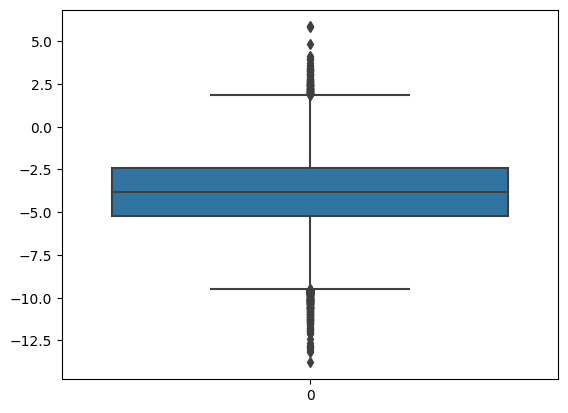

In [264]:
data = pd.read_csv('data/train.csv')
display(data.head())

# parentspecies column is categorical, so we need to convert it to numerical
data['parentspecies'] = data['parentspecies'].astype('category')
data['parentspecies'] = data['parentspecies'].cat.codes

# make psat_pa log base 10
data['pSat_Pa'] = np.log10(data['pSat_Pa'])

display(data.head())

# check for missing values
display(data.isnull().sum())

# check for outliers
sns.boxplot(data['pSat_Pa'])

# print sorted pSat_Pa values reverse order
print(np.sort(data['pSat_Pa'])[::-1])

# remove outliers
data = data[data['pSat_Pa'] < 4.7]
data = data[data['pSat_Pa'] > -13.5]

fit the model

In [353]:
#fit xgb model target is pSat_Pa
target = data['pSat_Pa']
features = data.drop(['pSat_Pa'], axis=1)
features = features.drop(['Id'], axis=1)

#standardize first 8 columns
features.iloc[:,0:8] = (features.iloc[:,0:8] - features.iloc[:,0:8].mean())/features.iloc[:,0:8].std()

model = lgb.LGBMRegressor(num_leaves=10, min_child_samples=50, learning_rate=0.1, n_estimators=500)

cv = KFold(n_splits=5)

scores = cross_val_score(model, features, target, cv=cv)

print('Mean MAE: %.3f' % scores.mean())

#fit hist gradient boosting model target is pSat_Pa

model3 = HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.07, max_iter=100)

cv = KFold(n_splits=5)

scores = cross_val_score(model3, features, target, cv=cv)

print('Mean MAE: %.3f' % scores.mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 21714, number of used features: 24
[LightGBM] [Info] Start training from score -3.679559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 21714, number of used features: 24
[LightGBM] [Info] Start training from score -3.993218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

Lets try different number of features

In [356]:
# at each iteration remove feature which decreases r2 score the least using backward selection

target = data['pSat_Pa']
features = data.drop(['pSat_Pa'], axis=1)
features = features.drop(['Id'], axis=1)

#standardize first 8 columns
features.iloc[:,0:8] = (features.iloc[:,0:8] - features.iloc[:,0:8].mean())/features.iloc[:,0:8].std()

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.05)

best_features = []

for i in range(0, len(features.columns)):

    if (i == len(features.columns) - 1):
        best_features.append(X_train.columns[0])
        break

    # find feature which improves r2 score the most
    r2_list = []
    for feature in X_train.columns:
        X_train_temp = X_train.copy()
        X_train_temp = X_train_temp.drop([feature], axis=1)
        X_test_temp = X_test.copy()
        X_test_temp = X_test_temp.drop([feature], axis=1)

        model = lgb.LGBMRegressor()

        model.fit(X_train_temp, y_train)

        # make predictions
        preds = model.predict(X_test_temp)

        # calculate rmse
        rmse = mean_squared_error(y_test, preds, squared=False)

        # r2 score
        r2 = r2_score(y_test, preds)

        r2_list.append(r2)

    # find feature which reduced r2 score the most
    r2_list = np.array(r2_list)
    best_feature = X_train.columns[np.argmax(r2_list)]

    # add best feature to X_train and X_test
    X_train = X_train.drop([best_feature], axis=1)
    X_test = X_test.drop([best_feature], axis=1)

    # add best feature to best_features
    best_features.append(best_feature)

best_features = best_features[::-1]
print(best_features)
print(len(best_features))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 25785, number of used features: 23
[LightGBM] [Info] Start training from score -3.852594
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 25785, number of used features: 23
[LightGBM] [Info] Start training from score -3.852594
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [357]:
# according to best_features list fit xgb model on 1, 2, ... n features and find best cv score

target = data['pSat_Pa']
features = data.drop(['pSat_Pa'], axis=1)
features = features.drop(['Id'], axis=1)

#standardize first 8 columns
features.iloc[:,0:8] = (features.iloc[:,0:8] - features.iloc[:,0:8].mean())/features.iloc[:,0:8].std()

models = []
r2_scores = []
cross_val_scores = []

random = np.random.randint(0, 100)

for i in range(15, len(best_features) + 1):
    temp_features = features[best_features[0:i]]
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(temp_features, target, test_size=0.05, random_state=random)
    
    m = lgb.LGBMRegressor(num_leaves=10, min_child_samples=50, learning_rate=0.1, n_estimators=500)
    
    models.append(m)

    m.fit(X_train, y_train)

    # make predictions
    preds = m.predict(X_test)

    # calculate r2
    score = r2_score(y_test, preds)
    r2_scores.append(score)

    #cross validation
    cv = KFold(n_splits=5)
    scores = cross_val_score(m, temp_features, target, cv=cv)
    score = np.mean(scores)
    cross_val_scores.append(score)

print(r2_scores)
print(cross_val_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 25785, number of used features: 15
[LightGBM] [Info] Start training from score -3.852557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 21714, number of used features: 15
[LightGBM] [Info] Start training from score -3.679559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

Make predictions on test data

In [362]:
test_data = pd.read_csv('data/test.csv')

# parentspecies column is categorical, so we need to convert it to numerical
test_data['parentspecies'] = test_data['parentspecies'].astype('category')
test_data['parentspecies'] = test_data['parentspecies'].cat.codes

# remove Id column
test_data_noID = test_data.drop(['Id'], axis=1)

#standardize first 8 columns
test_data_noID.iloc[:,0:8] = (test_data_noID.iloc[:,0:8] - test_data_noID.iloc[:,0:8].mean())/test_data_noID.iloc[:,0:8].std()

test_data_noID = test_data_noID[best_features[0:-5]]

models[-6].fit(features[best_features[0:-5]], target)

preds = models[-6].predict(test_data_noID)

# create submission file
submission = pd.DataFrame({'Id': test_data['Id'], 'target': preds})

submission.to_csv('submission.csv', index=False)

'''
Best model so far not including:
'nitroester', 
'MW', 
'carbonylperoxynitrate', 
'C.C.C.O.in.non.aromatic.ring', 
'aromatic.hydroxyl'
'''

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 27143, number of used features: 20
[LightGBM] [Info] Start training from score -3.854944
